<a href="https://colab.research.google.com/github/Rosefinch-Midsummer/Awesome-Colab/blob/master/fastai/10b_mixup_label_smoothing%2Bc_fp16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
!git clone https://github.com/fastai/course-v3

fatal: destination path 'course-v3' already exists and is not an empty directory.


In [3]:
cd course-v3/nbs/dl2

/content/course-v3/nbs/dl2


# Mixup / Label smoothing

In [0]:
#export
from exp.nb_10 import *
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

## Mixup

What is mixup?

As the name kind of suggests, the authors of the [mixup article ](https://arxiv.org/abs/1710.09412)propose to train the model on a mix of the pictures of the training set. Let's say we're on CIFAR10 for instance, then instead of feeding the model the raw images, we take two (which could be in the same class or not) and do a linear combination of them: in terms of tensor it's

new_image = t * image1 + (1-t) * image2
where t is a float between 0 and 1. Then the target we assign to that image is the same combination of the original targets:

new_target = t * target1 + (1-t) * target2
assuming your targets are one-hot encoded (which isn't the case in pytorch usually). And that's as simple as this.

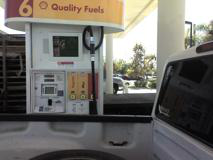

In [5]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

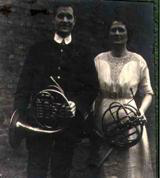

In [6]:
img2 = PIL.Image.open(ll.train.x.items[4000])
img2

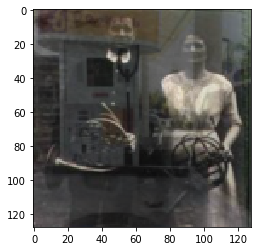

In [7]:
mixed_up = ll.train.x[0] * 0.3 + ll.train.x[4000] * 0.7
plt.imshow(mixed_up.permute(1,2,0));

## Implementation

The implementation relies on something called the beta distribution which in turns uses something which Jeremy still finds mildly terrifying called the gamma function. To get over his fears, Jeremy reminds himself that gamma is just a factorial function that (kinda) interpolates nice and smoothly to non-integers too. How it does that exactly isn't important...

In [0]:
# PyTorch has a log-gamma but not a gamma, so we'll create one
Γ = lambda x: x.lgamma().exp()



NB: If you see math symbols you don't know you can google them like this: Γ function.

If you're not used to typing unicode symbols, on Mac type ctrl-cmd-space to bring up a searchable emoji box. On Linux you can use the compose key. On Windows you can also use a compose key, but you first need to install WinCompose. By default the compose key is the right-hand Alt key.

You can search for symbol names in WinCompose. The greek letters are generally compose-\*-letter (where letter is, for instance, a to get greek α alpha).

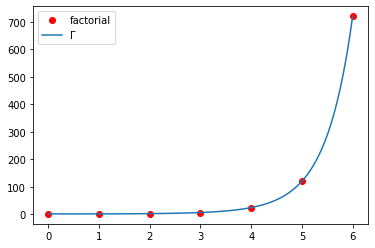

In [9]:
facts = [math.factorial(i) for i in range(7)]

plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.legend(['factorial','Γ']);

In [10]:
torch.linspace(0,0.9,10)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])

In the original article, the authors suggested three things:

- 1.Create two separate dataloaders and draw a batch from each at every iteration to mix them up

- 2.Draw a t value following a beta distribution with a parameter α (0.4 is suggested in their article)

- 3. Mix up the two batches with the same value t.

- 4.Use one-hot encoded targets

Why the beta distribution with the same parameters α? Well it looks like this:

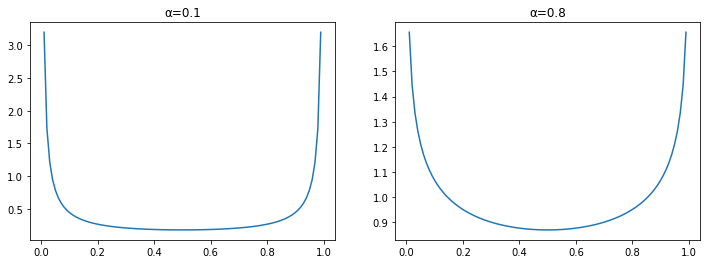

In [11]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1,0.8], axs):
    α = tensor(α)
#     y = (x.pow(α-1) * (1-x).pow(α-1)) / (gamma_func(α ** 2) / gamma_func(α))
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

With a low α, we pick values close to 0. and 1. with a high probability, and the values in the middle all have the same kind of probability. With a greater α, 0. and 1. get a lower probability .

While the approach above works very well, it's not the fastest way we can do this. The main point that slows down this process is wanting two different batches at every iteration (which means loading twice the amount of images and applying to them the other data augmentation function). To avoid this slow down, we can be a little smarter and mixup a batch with a shuffled version of itself (this way the images mixed up are still different). This was a trick suggested in the MixUp paper.

Then pytorch was very careful to avoid one-hot encoding targets when it could, so it seems a bit of a drag to undo this. Fortunately for us, if the loss is a classic cross-entropy, we have

loss(output, new_target) = t * loss(output, target1) + (1-t) * loss(output, target2)
so we won't one-hot encode anything and just compute those two losses then do the linear combination.

Using the same parameter t for the whole batch also seemed a bit inefficient. In our experiments, we noticed that the model can train faster if we draw a different t for every image in the batch (both options get to the same result in terms of accuracy, it's just that one arrives there more slowly). The last trick we have to apply with this is that there can be some duplicates with this strategy: let's say or shuffle say to mix image0 with image1 then image1 with image0, and that we draw t=0.1 for the first, and t=0.9 for the second. Then

image0 * 0.1 + shuffle0 * (1-0.1) = image0 * 0.1 + image1 * 0.9
image1 * 0.9 + shuffle1 * (1-0.9) = image1 * 0.9 + image0 * 0.1
will be the same. Of course, we have to be a bit unlucky but in practice, we saw there was a drop in accuracy by using this without removing those near-duplicates. To avoid them, the tricks is to replace the vector of parameters we drew by

t = max(t, 1-t)
The beta distribution with the two parameters equal is symmetric in any case, and this way we insure that the biggest coefficient is always near the first image (the non-shuffled batch).

In Mixup we have handle loss functions that have an attribute reduction (like nn.CrossEntropy()). To deal with the reduction=None with various types of loss function without modifying the actual loss function outside of the scope we need to perform those operations with no reduction, we create a context manager:

In [0]:
#export
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)

In [0]:
#Then we can use it in MixUp:

#export
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [0]:
#export
class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [0]:
nfs = [32,64,128,256,512]

def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [16]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixUp]

learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.044953,0.218551,2.176063,0.314000,00:20


Questions: How does softmax interact with all this? Should we jump straight from mixup to inference?

## Label smoothing

Another regularization technique that's often used is label smoothing. It's designed to make the model a little bit less certain of it's decision by changing a little bit its target: instead of wanting to predict 1 for the correct class and 0 for all the others, we ask it to predict 1-ε for the correct class and ε for all the others, with ε a (small) positive number and N the number of classes. This can be written as:

$$loss = (1-ε) ce(i) + ε \sum ce(j) / N$$
where ce(x) is cross-entropy of x (i.e. $-\log(p_{x})$), and i is the correct class. This can be coded in a loss function:

In [0]:
#export
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

Note: we implement the various reduction attributes so that it plays nicely with MixUp after.

In [18]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs, loss_func=LabelSmoothingCrossEntropy())
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.848476,0.266713,2.349072,0.330000,00:20


And we can check our loss function reduction attribute hasn't changed outside of the training loop:

In [0]:
assert learn.loss_func.reduction == 'mean'

## Export

In [0]:
#./notebook2script.py 10b_mixup_label_smoothing.ipynb

# Training in mixed precision

In [0]:
#export
from exp.nb_10b import *

## A little bit of theory

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1318)

Continuing the documentation on the fastai_v1 development here is a brief piece about mixed precision training. A very nice and clear introduction to it is [this video from NVIDIA](http://on-demand.gputechconf.com/gtc/2018/video/S81012/).

### What's half precision?
In neural nets, all the computations are usually done in single precision, which means all the floats in all the arrays that represent inputs, activations, weights... are 32-bit floats (FP32 in the rest of this post). An idea to reduce memory usage (and avoid those annoying cuda errors) has been to try and do the same thing in half-precision, which means using 16-bits floats (or FP16 in the rest of this post). By definition, they take half the space in RAM, and in theory could allow you to double the size of your model and double your batch size.

Another very nice feature is that NVIDIA developed its latest GPUs (the Volta generation) to take fully advantage of half-precision tensors. Basically, if you give half-precision tensors to those, they'll stack them so that each core can do more operations at the same time, and theoretically gives an 8x speed-up (sadly, just in theory).

So training at half precision is better for your memory usage, way faster if you have a Volta GPU (still a tiny bit faster if you don't since the computations are easiest). How do we do it? Super easily in pytorch, we just have to put .half() everywhere: on the inputs of our model and all the parameters. Problem is that you usually won't see the same accuracy in the end (so it happens sometimes) because half-precision is... well... not as precise ;).

### Problems with half-precision:
To understand the problems with half precision, let's look briefly at what an FP16 looks like (more information [here](https://en.wikipedia.org/wiki/Half-precision_floating-point_format)).

![half float](https://github.com/fastai/course-v3/blob/master/nbs/dl2/images/half.png?raw=1)

The sign bit gives us +1 or -1, then we have 5 bits to code an exponent between -14 and 15, while the fraction part has the remaining 10 bits. Compared to FP32, we have a smaller range of possible values (2e-14 to 2e15 roughly, compared to 2e-126 to 2e127 for FP32) but also a smaller *offset*.

For instance, between 1 and 2, the FP16 format only represents the number 1, 1+2e-10, 1+2*2e-10... which means that 1 + 0.0001 = 1 in half precision. That's what will cause a certain numbers of problems, specifically three that can occur and mess up your training.
1. The weight update is imprecise: inside your optimizer, you basically do w = w - lr * w.grad for each weight of your network. The problem in performing this operation in half precision is that very often, w.grad is several orders of magnitude below w, and the learning rate is also small. The situation where w=1 and lr*w.grad is 0.0001 (or lower) is therefore very common, but the update doesn't do anything in those cases.
2. Your gradients can underflow. In FP16, your gradients can easily be replaced by 0 because they are too low.
3. Your activations or loss can overflow. The opposite problem from the gradients: it's easier to hit nan (or infinity) in FP16 precision, and your training might more easily diverge.

### The solution: mixed precision training

To address those three problems, we don't fully train in FP16 precision. As the name mixed training implies, some of the operations will be done in FP16, others in FP32. This is mainly to take care of the first problem listed above. For the next two there are additional tricks.

The main idea is that we want to do the forward pass and the gradient computation in half precision (to go fast) but the update in single precision (to be more precise). It's okay if w and grad are both half floats, but when we do the operation w = w - lr * grad, we need to compute it in FP32. That way our 1 + 0.0001 is going to be 1.0001. 

This is why we keep a copy of the weights in FP32 (called master model). Then, our training loop will look like:
1. compute the output with the FP16 model, then the loss
2. back-propagate the gradients in half-precision.
3. copy the gradients in FP32 precision
4. do the update on the master model (in FP32 precision)
5. copy the master model in the FP16 model.

Note that we lose precision during step 5, and that the 1.0001 in one of the weights will go back to 1. But if the next update corresponds to add 0.0001 again, since the optimizer step is done on the master model, the 1.0001 will become 1.0002 and if we eventually go like this up to 1.0005, the FP16 model will be able to tell the difference.

That takes care of problem 1. For the second problem, we use something called gradient scaling: to avoid the gradients getting zeroed by the FP16 precision, we multiply the loss by a scale factor (scale=512 for instance). That way we can push the gradients to the right in the next figure, and have them not become zero.

![half float representation](https://github.com/fastai/course-v3/blob/master/nbs/dl2/images/half_representation.png?raw=1)

Of course we don't want those 512-scaled gradients to be in the weight update, so after converting them into FP32, we can divide them by this scale factor (once they have no risks of becoming 0). This changes the loop to:
1. compute the output with the FP16 model, then the loss.
2. multiply the loss by scale then back-propagate the gradients in half-precision.
3. copy the gradients in FP32 precision then divide them by scale.
4. do the update on the master model (in FP32 precision).
5. copy the master model in the FP16 model.

For the last problem, the tricks offered by NVIDIA are to leave the batchnorm layers in single precision (they don't have many weights so it's not a big memory challenge) and compute the loss in single precision (which means converting the last output of the model in single precision before passing it to the loss).

![Mixed precision training](https://github.com/fastai/course-v3/blob/master/nbs/dl2/images/Mixed_precision.jpeg?raw=1)

Implementing all of this in the new callback system is surprisingly easy, let's dig into this!

## Util functions

Before going in the main `Callback` we will need some helper functions. We will refactor using the [APEX library](https://github.com/NVIDIA/apex) util functions. The python-only build is enough for what we will use here if you don't manage to do the CUDA/C++ installation.

In [0]:
!git clone https://www.github.com/nvidia/apex  && cd apex/apex/fp16_utils

In [0]:
# export 
import fp16util as fp16
#from apex import amp

### Converting the model to FP16

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1425)

We will need a function to convert all the layers of the model to FP16 precision except the BatchNorm-like layers (since those need to be done in FP32 precision to be stable). We do this in two steps: first we convert the model to FP16, then we loop over all the layers and put them back to FP32 if they are a BatchNorm layer.

In [0]:
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

In [0]:
def bn_to_float(model):
    if isinstance(model, bn_types): model.float()
    for child in model.children():  bn_to_float(child)
    return model

In [0]:
def model_to_half(model):
    model = model.half()
    return bn_to_float(model)

Let's test this:

In [0]:
model = nn.Sequential(nn.Linear(10,30), nn.BatchNorm1d(30), nn.Linear(30,2)).cuda()
model = model_to_half(model)

In [0]:
def check_weights(model):
    for i,t in enumerate([torch.float16, torch.float32, torch.float16]):
        assert model[i].weight.dtype == t
        assert model[i].bias.dtype   == t

In [0]:
check_weights(model)

In Apex, the function that does this for us is `convert_network`. We can use it to put the model in FP16 or back to FP32.

In [0]:
model = nn.Sequential(nn.Linear(10,30), nn.BatchNorm1d(30), nn.Linear(30,2)).cuda()
model = fp16.convert_network(model, torch.float16)
check_weights(model)

### Creating the master copy of the parameters

From our model parameters (mostly in FP16), we'll want to create a copy in FP32 (master parameters) that we will use for the step in the optimizer. Optionally, we concatenate all the parameters to do one flat big tensor, which can make that step a little bit faster.

In [0]:
from torch.nn.utils import parameters_to_vector

def get_master(model, flat_master=False):
    model_params = [param for param in model.parameters() if param.requires_grad]
    if flat_master:
        master_param = parameters_to_vector([param.data.float() for param in model_params])
        master_param = torch.nn.Parameter(master_param, requires_grad=True)
        if master_param.grad is None: master_param.grad = master_param.new(*master_param.size())
        return model_params, [master_param]
    else:
        master_params = [param.clone().float().detach() for param in model_params]
        for param in master_params: param.requires_grad_(True)
        return model_params, master_params

The util function from Apex to do this is `prep_param_lists`.

In [0]:
model_p,master_p = get_master(model)
model_p1,master_p1 = fp16.prep_param_lists(model)

In [0]:
def same_lists(ps1, ps2):
    assert len(ps1) == len(ps2)
    for (p1,p2) in zip(ps1,ps2): 
        assert p1.requires_grad == p2.requires_grad
        assert torch.allclose(p1.data.float(), p2.data.float())

In [0]:
same_lists(model_p,model_p1)
same_lists(model_p,master_p)
same_lists(master_p,master_p1)
same_lists(model_p1,master_p1)

We can't use flat_master when there is a mix of FP32 and FP16 parameters (like batchnorm here).

In [0]:
model1 = nn.Sequential(nn.Linear(10,30), nn.Linear(30,2)).cuda()
model1 = fp16.convert_network(model1, torch.float16)

In [0]:
model_p,master_p = get_master(model1, flat_master=True)
model_p1,master_p1 = fp16.prep_param_lists(model1, flat_master=True)

In [0]:
same_lists(model_p,model_p1)
same_lists(master_p,master_p1)

In [0]:
assert len(master_p[0]) == 10*30 + 30 + 30*2 + 2
assert len(master_p1[0]) == 10*30 + 30 + 30*2 + 2

The thing is that we don't always want all the parameters of our model in the same parameter group, because we might:
- want to do transfer learning and freeze some layers
- apply discriminative learning rates
- don't apply weight decay to some layers (like BatchNorm) or the bias terms

So we actually need a function that splits the parameters of an optimizer (and not a model) according to the right parameter groups.

In [0]:
def get_master(opt, flat_master=False):
    model_params = [[param for param in pg if param.requires_grad] for pg in opt.param_groups]
    if flat_master:
        master_params = []
        for pg in model_params:
            mp = parameters_to_vector([param.data.float() for param in pg])
            mp = torch.nn.Parameter(mp, requires_grad=True)
            if mp.grad is None: mp.grad = mp.new(*mp.size())
            master_params.append(mp)
    else:
        master_params = [[param.clone().float().detach() for param in pg] for pg in model_params]
        for pg in master_params:
            for param in pg: param.requires_grad_(True)
    return model_params, master_params

### Copy the gradients from model params to master params

After the backward pass, all gradients must be copied to the master params before the optimizer step can be done in FP32. We need a function for that (with a bit of adjustement if we have flat master).

In [0]:
def to_master_grads(model_params, master_params, flat_master:bool=False)->None:
    if flat_master:
        if master_params[0].grad is None: master_params[0].grad = master_params[0].data.new(*master_params[0].data.size())
        master_params[0].grad.data.copy_(parameters_to_vector([p.grad.data.float() for p in model_params]))
    else:
        for model, master in zip(model_params, master_params):
            if model.grad is not None:
                if master.grad is None: master.grad = master.data.new(*master.data.size())
                master.grad.data.copy_(model.grad.data)
            else: master.grad = None

The corresponding function in the Apex utils is `model_grads_to_master_grads`.

In [0]:
x = torch.randn(20,10).half().cuda()
z = model(x)
loss = F.cross_entropy(z, torch.randint(0, 2, (20,)).cuda())
loss.backward()

In [0]:
to_master_grads(model_p, master_p)

In [0]:
def check_grads(m1, m2):
    for p1,p2 in zip(m1,m2): 
        if p1.grad is None: assert p2.grad is None
        else: assert torch.allclose(p1.grad.data, p2.grad.data) 

In [0]:
check_grads(model_p, master_p)

In [0]:
fp16.model_grads_to_master_grads(model_p, master_p)

In [0]:
check_grads(model_p, master_p)

### Copy the master params to the model params

After the step, we need to copy back the master parameters to the model parameters for the next update.

In [0]:
from torch._utils import _unflatten_dense_tensors

def to_model_params(model_params, master_params, flat_master:bool=False)->None:
    if flat_master:
        for model, master in zip(model_params, _unflatten_dense_tensors(master_params[0].data, model_params)):
            model.data.copy_(master)
    else:
        for model, master in zip(model_params, master_params): model.data.copy_(master.data)

The corresponding function in Apex is `master_params_to_model_params`.

### But we need to handle param groups

The thing is that we don't always want all the parameters of our model in the same parameter group, because we might:
- want to do transfer learning and freeze some layers
- apply discriminative learning rates
- don't apply weight decay to some layers (like BatchNorm) or the bias terms

So we actually need a function that splits the parameters of an optimizer (and not a model) according to the right parameter groups and the following functions need to handle lists of lists of parameters (one list of each param group in `model_pgs` and `master_pgs`)

In [0]:
# export 
def get_master(opt, flat_master=False):
    model_pgs = [[param for param in pg if param.requires_grad] for pg in opt.param_groups]
    if flat_master:
        master_pgs = []
        for pg in model_pgs:
            mp = parameters_to_vector([param.data.float() for param in pg])
            mp = torch.nn.Parameter(mp, requires_grad=True)
            if mp.grad is None: mp.grad = mp.new(*mp.size())
            master_pgs.append([mp])
    else:
        master_pgs = [[param.clone().float().detach() for param in pg] for pg in model_pgs]
        for pg in master_pgs:
            for param in pg: param.requires_grad_(True)
    return model_pgs, master_pgs

In [0]:
# export 
def to_master_grads(model_pgs, master_pgs, flat_master:bool=False)->None:
    for (model_params,master_params) in zip(model_pgs,master_pgs):
        fp16.model_grads_to_master_grads(model_params, master_params, flat_master=flat_master)

In [0]:
# export 
def to_model_params(model_pgs, master_pgs, flat_master:bool=False)->None:
    for (model_params,master_params) in zip(model_pgs,master_pgs):
        fp16.master_params_to_model_params(model_params, master_params, flat_master=flat_master)

## The main Callback

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1452)

In [0]:
class MixedPrecision(Callback):
    _order = 99
    def __init__(self, loss_scale=512, flat_master=False):
        assert torch.backends.cudnn.enabled, "Mixed precision training requires cudnn."
        self.loss_scale,self.flat_master = loss_scale,flat_master

    def begin_fit(self):
        self.run.model = fp16.convert_network(self.model, dtype=torch.float16)
        self.model_pgs, self.master_pgs = get_master(self.opt, self.flat_master)
        #Changes the optimizer so that the optimization step is done in FP32.
        self.run.opt.param_groups = self.master_pgs #Put those param groups inside our runner.
        
    def after_fit(self): self.model.float()

    def begin_batch(self): self.run.xb = self.run.xb.half() #Put the inputs to half precision
    def after_pred(self):  self.run.pred = self.run.pred.float() #Compute the loss in FP32
    def after_loss(self):  self.run.loss *= self.loss_scale #Loss scaling to avoid gradient underflow

    def after_backward(self):
        #Copy the gradients to master and unscale
        to_master_grads(self.model_pgs, self.master_pgs, self.flat_master)
        for master_params in self.master_pgs:
            for param in master_params:
                if param.grad is not None: param.grad.div_(self.loss_scale)

    def after_step(self):
        #Zero the gradients of the model since the optimizer is disconnected.
        self.model.zero_grad()
        #Update the params from master to model.
        to_model_params(self.model_pgs, self.master_pgs, self.flat_master)

Now let's test this on Imagenette

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [0]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [0]:
nfs = [32,64,128,256,512]

In [0]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=adam_opt(), **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

Training without mixed precision

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        ProgressCallback,
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [0]:
learn = get_learner(nfs, data, 1e-2, conv_layer, cb_funcs=cbfs)

In [78]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.889438,0.382271,1.524756,0.486000,00:21


Training with mixed precision

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixedPrecision]

In [0]:
learn = get_learner(nfs, data, 1e-2, conv_layer, cb_funcs=cbfs)

In [81]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.887072,0.389794,1.512170,0.498000,00:22


In [0]:
test_eq(next(learn.model.parameters()).type(), 'torch.cuda.FloatTensor')

## Dynamic loss scaling

The only annoying thing with the previous implementation of mixed precision training is that it introduces one new hyper-parameter to tune, the value of the loss scaling. Fortunately for us, there is a way around this. We want the loss scaling to be as high as possible so that our gradients can use the whole range of representation, so let's first try a really high value. In all likelihood, this will cause our gradients or our loss to overflow, and we will try again with half that big value, and again, until we get to the largest loss scale possible that doesn't make our gradients overflow.

This value will be perfectly fitted to our model and can continue to be dynamically adjusted as the training goes, if it's still too high, by just halving it each time we overflow. After a while though, training will converge and gradients will start to get smaller, so we also need a mechanism to get this dynamic loss scale larger if it's safe to do so. The strategy used in the Apex library is to multiply the loss scale by 2 each time we had a given number of iterations without overflowing.

To check if the gradients have overflowed, we check their sum (computed in FP32). If one term is nan, the sum will be nan. Interestingly, on the GPU, it's faster than checking `torch.isnan`:

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1472)

In [0]:
# export 
def test_overflow(x):
    s = float(x.float().sum())
    return (s == float('inf') or s == float('-inf') or s != s)

In [0]:
x = torch.randn(512,1024).cuda()

In [85]:
test_overflow(x)

False

In [86]:
x[123,145] = float('inf')
test_overflow(x)

True

In [87]:
%timeit test_overflow(x)

The slowest run took 4.68 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 52.3 µs per loop


In [88]:
%timeit torch.isnan(x).any().item()

The slowest run took 10.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 64 µs per loop


So we can use it in the following function that checks for gradient overflow:

In [0]:
# export 
def grad_overflow(param_groups):
    for group in param_groups:
        for p in group:
            if p.grad is not None:
                s = float(p.grad.data.float().sum())
                if s == float('inf') or s == float('-inf') or s != s: return True
    return False

And now we can write a new version of the `Callback` that handles dynamic loss scaling.

In [0]:
# export 
class MixedPrecision(Callback):
    _order = 99
    def __init__(self, loss_scale=512, flat_master=False, dynamic=True, max_loss_scale=2.**24, div_factor=2.,
                 scale_wait=500):
        assert torch.backends.cudnn.enabled, "Mixed precision training requires cudnn."
        self.flat_master,self.dynamic,self.max_loss_scale = flat_master,dynamic,max_loss_scale
        self.div_factor,self.scale_wait = div_factor,scale_wait
        self.loss_scale = max_loss_scale if dynamic else loss_scale

    def begin_fit(self):
        self.run.model = fp16.convert_network(self.model, dtype=torch.float16)
        self.model_pgs, self.master_pgs = get_master(self.opt, self.flat_master)
        #Changes the optimizer so that the optimization step is done in FP32.
        self.run.opt.param_groups = self.master_pgs #Put those param groups inside our runner.
        if self.dynamic: self.count = 0

    def begin_batch(self): self.run.xb = self.run.xb.half() #Put the inputs to half precision
    def after_pred(self):  self.run.pred = self.run.pred.float() #Compute the loss in FP32
    def after_loss(self):  
        if self.in_train: self.run.loss *= self.loss_scale #Loss scaling to avoid gradient underflow

    def after_backward(self):
        #First, check for an overflow
        if self.dynamic and grad_overflow(self.model_pgs):
            #Divide the loss scale by div_factor, zero the grad (after_step will be skipped)
            self.loss_scale /= self.div_factor
            self.model.zero_grad()
            return True #skip step and zero_grad
        #Copy the gradients to master and unscale
        to_master_grads(self.model_pgs, self.master_pgs, self.flat_master)
        for master_params in self.master_pgs:
            for param in master_params:
                if param.grad is not None: param.grad.div_(self.loss_scale)
        #Check if it's been long enough without overflow
        if self.dynamic:
            self.count += 1
            if self.count == self.scale_wait:
                self.count = 0
                self.loss_scale *= self.div_factor

    def after_step(self):
        #Zero the gradients of the model since the optimizer is disconnected.
        self.model.zero_grad()
        #Update the params from master to model.
        to_model_params(self.model_pgs, self.master_pgs, self.flat_master)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixedPrecision]

In [0]:
learn = get_learner(nfs, data, 1e-2, conv_layer, cb_funcs=cbfs)

In [93]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.940661,0.365364,1.619411,0.430000,00:22


The loss scale used is way higher than our previous number:

In [94]:
learn.cbs[-1].loss_scale

65536.0

## Export

In [95]:
!./notebook2script.py 10c_fp16.ipynb

/bin/bash: ./notebook2script.py: No such file or directory
